**Analisis dan Prediksi Putus Sekolah Janjang Sekolah Dasar di Indonesia Berdasarkan Indikator Pendidikan Per Provinsi Menggunakan Machine Learning**

Import Library & Upload Dataset

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

FILE_PATH = "kelayakan_pendidikan_indonesia_rapi fiks.xlsx"
df = pd.read_excel(FILE_PATH)

Saving kelayakan_pendidikan_indonesia_rapi fiks.xlsx to kelayakan_pendidikan_indonesia_rapi fiks.xlsx


Load Data & Standarisasi Nama Kolom

In [ ]:
print("Shape:", df.shape)
df.head()
df.columns

Shape: (39, 14)


Index(['`provinsi`', '`sekolah`', '`siswa`', '`mengulang`', '`putus_sekolah`',
       '`kepala_sekolah_dan_gurults1`', '`kepala_sekolah_dan_guruge_s1`',
       '`tenaga_kependidikansm`', '`tenaga_kependidikangtsm`',
       '`rombongan_belajar`', '`ruang_kelasbaik`', '`ruang_kelasrusak_ringan`',
       '`ruang_kelasrusak_sedang`', '`ruang_kelasrusak_berat`'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.strip().str.replace("`", "", regex=False)
df.columns

Index(['provinsi', 'sekolah', 'siswa', 'mengulang', 'putus_sekolah',
       'kepala_sekolah_dan_gurults1', 'kepala_sekolah_dan_guruge_s1',
       'tenaga_kependidikansm', 'tenaga_kependidikangtsm', 'rombongan_belajar',
       'ruang_kelasbaik', 'ruang_kelasrusak_ringan', 'ruang_kelasrusak_sedang',
       'ruang_kelasrusak_berat'],
      dtype='object')

Ringkasan KPI (Untuk Dashboard Overview)

In [ ]:
TARGET = "putus_sekolah"

kpi = {
    "Total Putus Sekolah": df[TARGET].sum(),
    "Rata-rata Putus Sekolah": df[TARGET].mean(),
    "Median Putus Sekolah": df[TARGET].median(),
    "Provinsi Max Putus Sekolah": df.loc[df[TARGET].idxmax(), "provinsi"],
    "Nilai Max Putus Sekolah": df[TARGET].max(),
}

kpi_df = pd.DataFrame(
    kpi.items(),
    columns=["Indikator", "Nilai"]
)
kpi_df

,Indikator,Nilai
0,Total Putus Sekolah,45047
1,Rata-rata Putus Sekolah,1155.051282
2,Median Putus Sekolah,835.0
3,Provinsi Max Putus Sekolah,Prov. Jawa Barat
4,Nilai Max Putus Sekolah,5675


Visualisasi Deskriptif (Top/Bottom Provinsi & Distribusi Target)

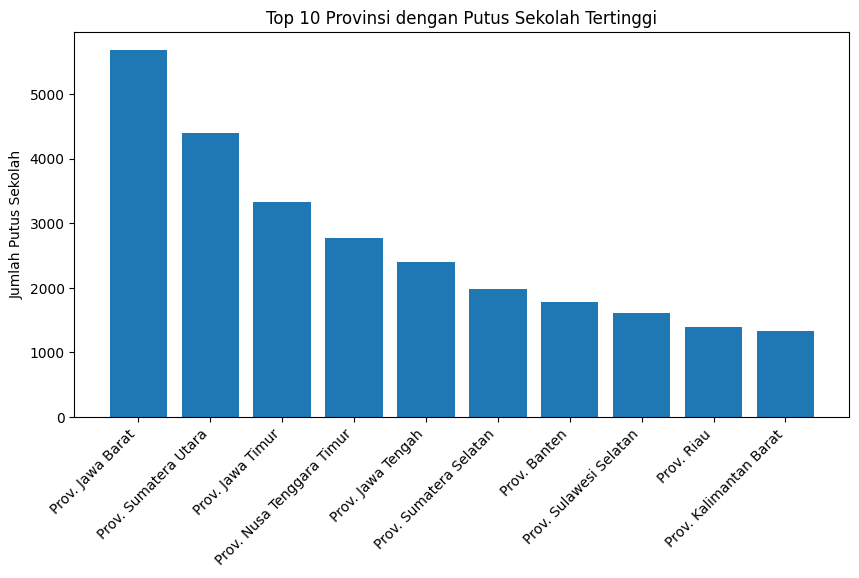

In [ ]:
top10 = df.sort_values(TARGET, ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(top10["provinsi"], top10[TARGET])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Provinsi dengan Putus Sekolah Tertinggi")
plt.ylabel("Jumlah Putus Sekolah")
plt.show()

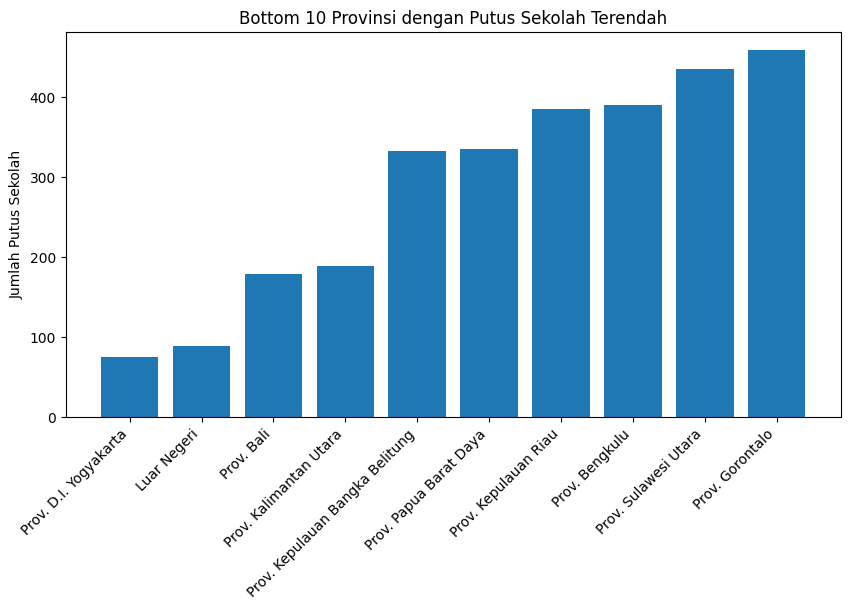

In [ ]:
bot10 = df.sort_values(TARGET, ascending=True).head(10)

plt.figure(figsize=(10,5))
plt.bar(bot10["provinsi"], bot10[TARGET])
plt.xticks(rotation=45, ha="right")
plt.title("Bottom 10 Provinsi dengan Putus Sekolah Terendah")
plt.ylabel("Jumlah Putus Sekolah")
plt.show()

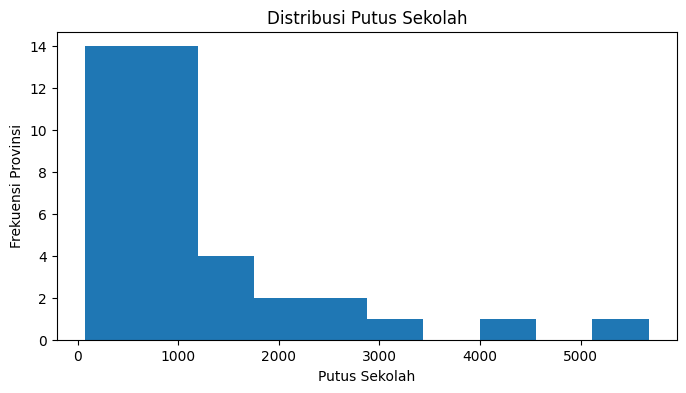

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df[TARGET], bins=10)
plt.title("Distribusi Putus Sekolah")
plt.xlabel("Putus Sekolah")
plt.ylabel("Frekuensi Provinsi")
plt.show()

Korelasi Antar Variabel (Insight Awal)

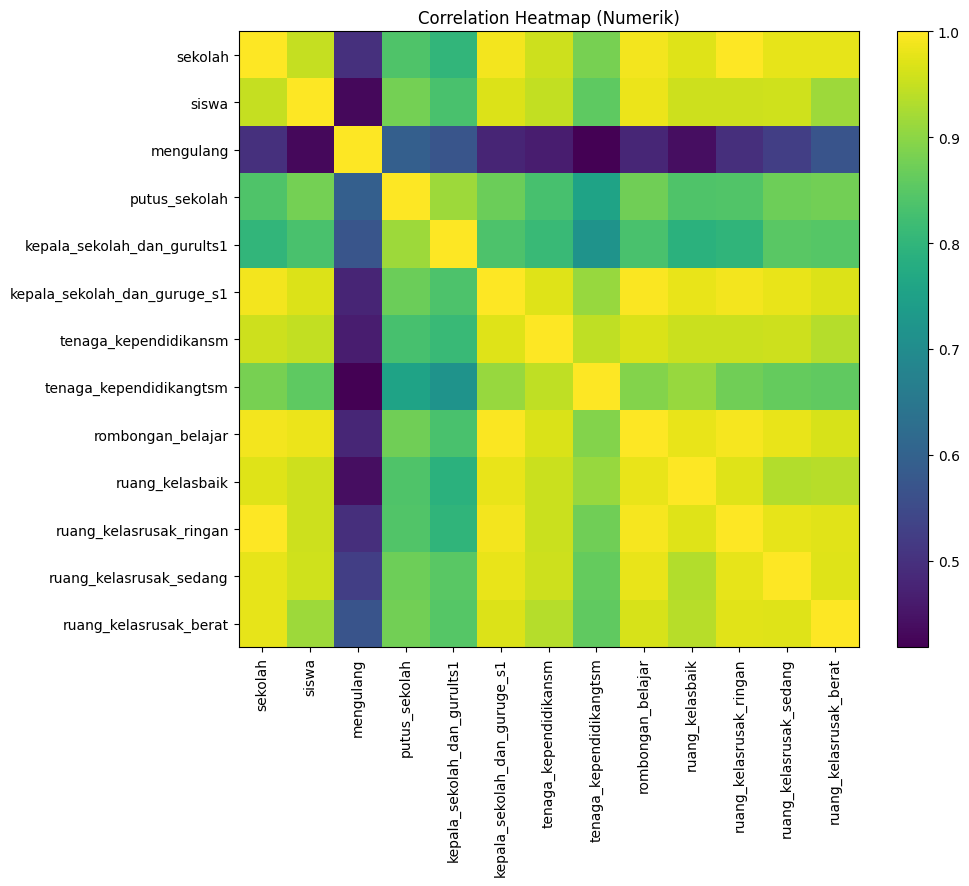

In [ ]:
num_df = df.select_dtypes(include=[np.number]).copy()

corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Numerik)")
plt.show()

Persiapan Data untuk Model (Split Data)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET])
y = df[TARGET]

# drop provinsi biar ga bikin model hafalan nama
if "provinsi" in X.columns:
    X = X.drop(columns=["provinsi"])

# kalau ada kolom non-numerik lain, buang dulu
X = X.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Training Model (Random Forest Regressor)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

Evaluasi Model (MAE, RMSE, R²)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

mae, rmse, r2

eval_df = pd.DataFrame({
    "Model": ["Random Forest"],
    "MAE": [mae],
    "RMSE": [rmse],
    "R2": [r2]
})
eval_df

,Model,MAE,RMSE,R2
0,Random Forest,415.309583,783.478762,0.701948


5-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    rf_model,
    X,
    y,
    cv=cv,
    scoring="r2"
)

cv_df = pd.DataFrame({
    "Metric": ["R2"],
    "Mean": [cv_scores.mean()],
    "Std": [cv_scores.std()]
})

cv_df

,Metric,Mean,Std
0,R2,0.506283,0.304164


Visual Evaluasi Model (Actual vs Predicted, Residual Plot, Error Terbesar)

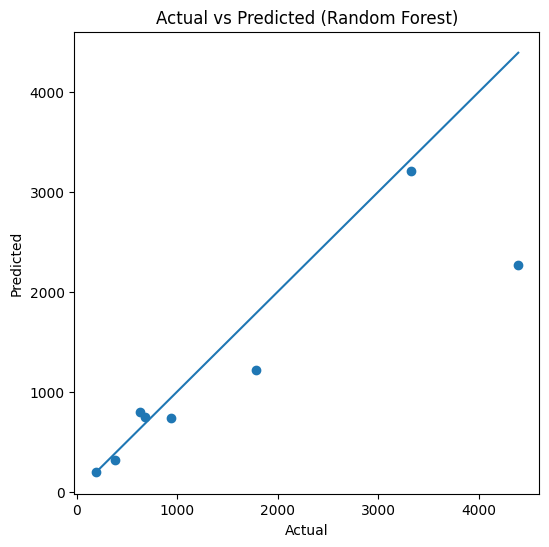

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred)
plt.title("Actual vs Predicted (Random Forest)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# garis ideal y=x
mn = min(y_test.min(), pred.min())
mx = max(y_test.max(), pred.max())
plt.plot([mn, mx], [mn, mx])
plt.show()

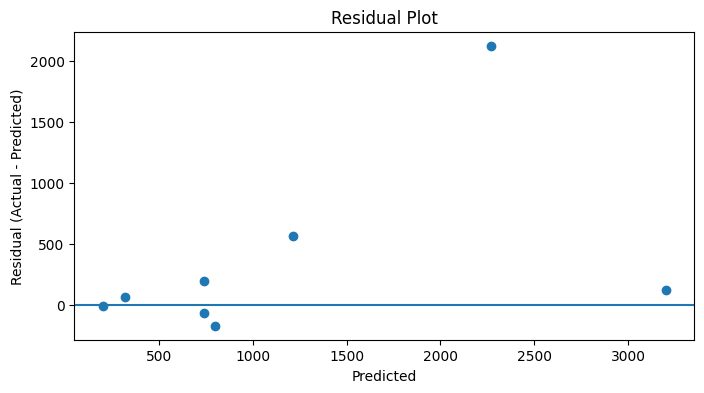

In [ ]:
residual = y_test - pred

plt.figure(figsize=(8,4))
plt.scatter(pred, residual)
plt.axhline(0)
plt.title("Residual Plot")
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

In [ ]:
df_idx = df.copy()
prov = df_idx["provinsi"]

X_full = df_idx.drop(columns=[TARGET])
if "provinsi" in X_full.columns:
    X_full_num = X_full.drop(columns=["provinsi"]).select_dtypes(include=[np.number])
else:
    X_full_num = X_full.select_dtypes(include=[np.number])

X_train2, X_test2, y_train2, y_test2, prov_train, prov_test = train_test_split(
    X_full_num, y, prov, test_size=0.2, random_state=42
)

rf_model2 = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model2.fit(X_train2, y_train2)

pred2 = rf_model2.predict(X_test2)
err_abs = np.abs(y_test2 - pred2)

err_df = pd.DataFrame({
    "provinsi": prov_test.values,
    "actual": y_test2.values,
    "pred": pred2,
    "abs_error": err_abs
}).sort_values("abs_error", ascending=False)

err_df.head(10)

,provinsi,actual,pred,abs_error
6,Prov. Sumatera Utara,4390,2268.956667,2121.043333
27,Prov. Banten,1779,1213.106667,565.893333
36,Prov. Papua Selatan,936,739.906667,196.093333
26,Prov. Maluku Utara,630,799.666667,169.666667
4,Prov. Jawa Timur,3327,3204.020000,122.980000
30,Prov. Kepulauan Riau,385,316.616667,68.383333
13,Prov. Kalimantan Tengah,675,741.933333,66.933333
33,Prov. Kalimantan Utara,188,199.483333,11.483333


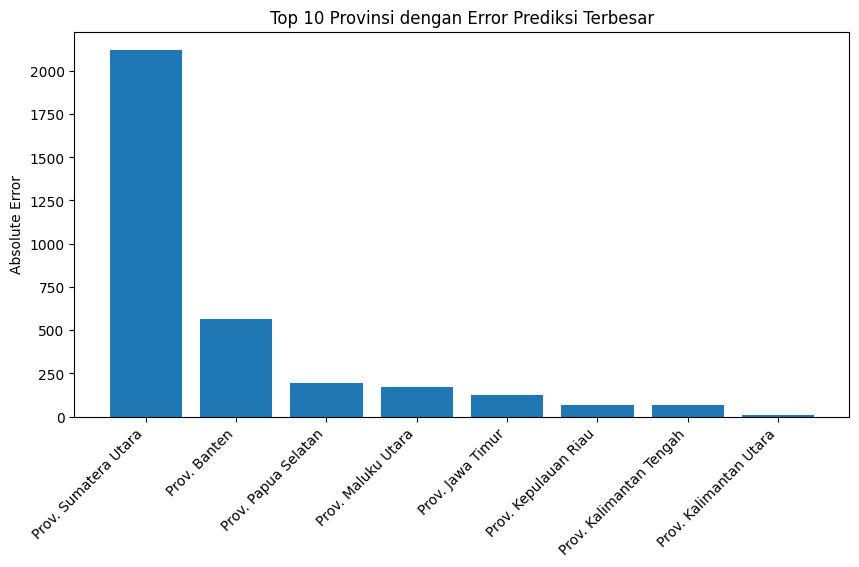

In [ ]:
top_err = err_df.head(10)

plt.figure(figsize=(10,5))
plt.bar(top_err["provinsi"], top_err["abs_error"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Provinsi dengan Error Prediksi Terbesar")
plt.ylabel("Absolute Error")
plt.show()

Interpretasi Model: Feature Importance

In [ ]:
fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

fi.head(10)

,feature,importance
3,kepala_sekolah_dan_gurults1,0.226890
2,mengulang,0.110899
11,ruang_kelasrusak_berat,0.097368
9,ruang_kelasrusak_ringan,0.079623
10,ruang_kelasrusak_sedang,0.079176
5,tenaga_kependidikansm,0.070089
0,sekolah,0.069504
7,rombongan_belajar,0.059036
1,siswa,0.057606
4,kepala_sekolah_dan_guruge_s1,0.055445


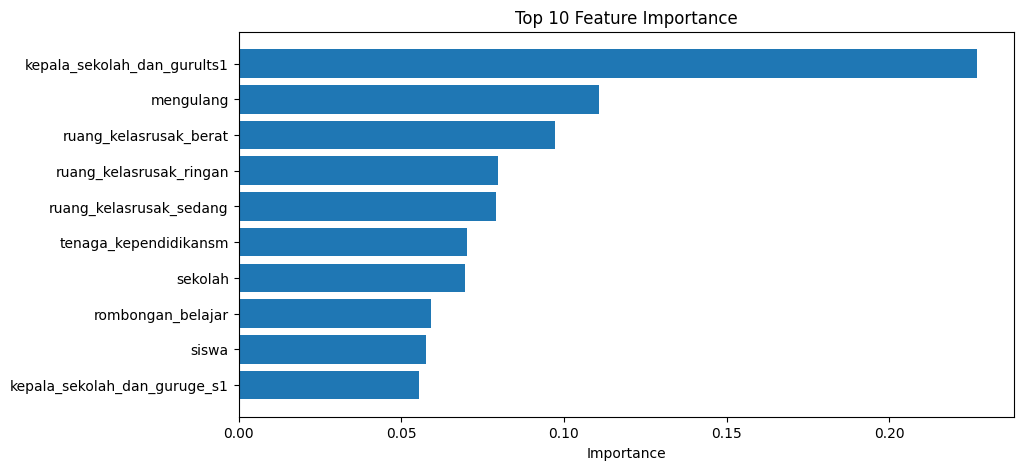

In [ ]:
topfi = fi.head(10).iloc[::-1]

plt.figure(figsize=(10,5))
plt.barh(topfi["feature"], topfi["importance"])
plt.title("Top 10 Feature Importance")
plt.xlabel("Importance")
plt.show()

Mendeteksi Oulier

Menggunakan Metode Box Plot

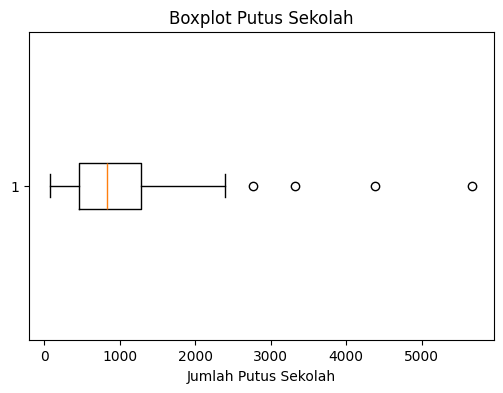

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot(df[TARGET], vert=False)
plt.title("Boxplot Putus Sekolah")
plt.xlabel("Jumlah Putus Sekolah")
plt.show()

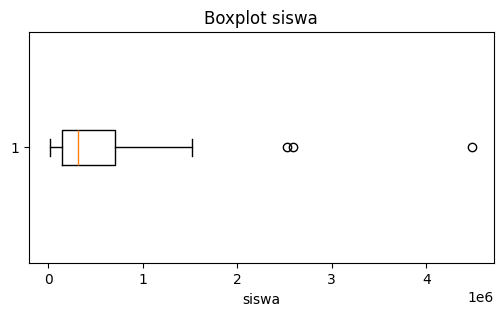

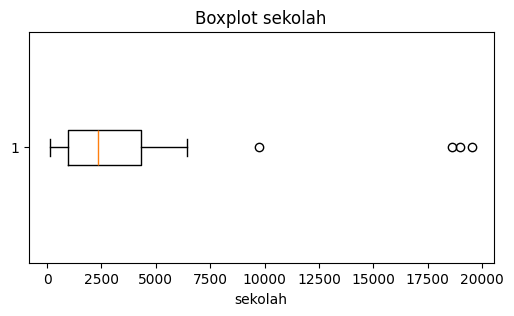

In [ ]:
features_check = ["siswa", "sekolah", "guru"]

for col in features_check:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        plt.boxplot(df[col], vert=False)
        plt.title(f"Boxplot {col}")
        plt.xlabel(col)
        plt.show()

Menggunakan Metode IQR

In [ ]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return series[(series < lower) | (series > upper)]

In [ ]:
out_putus = detect_outliers_iqr(df[TARGET])
out_putus

,putus_sekolah
1,5675
4,3327
6,4390
23,2771


In [ ]:
PROV = "provinsi"
df.loc[out_putus.index, [PROV, TARGET]]

,provinsi,putus_sekolah
1,Prov. Jawa Barat,5675
4,Prov. Jawa Timur,3327
6,Prov. Sumatera Utara,4390
23,Prov. Nusa Tenggara Timur,2771


VISUALISASI OUTLIER ; SCATTER

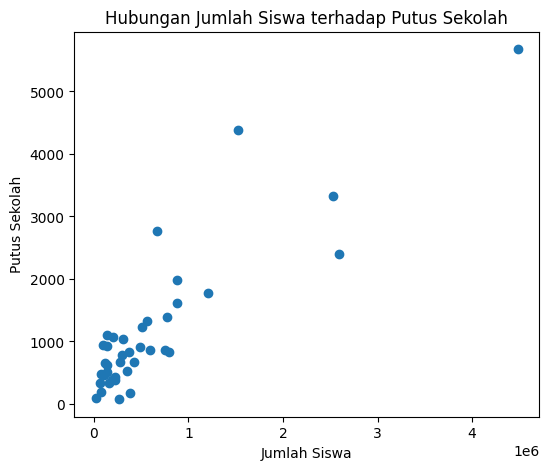

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(df["siswa"], df[TARGET])
plt.xlabel("Jumlah Siswa")
plt.ylabel("Putus Sekolah")
plt.title("Hubungan Jumlah Siswa terhadap Putus Sekolah")
plt.show()

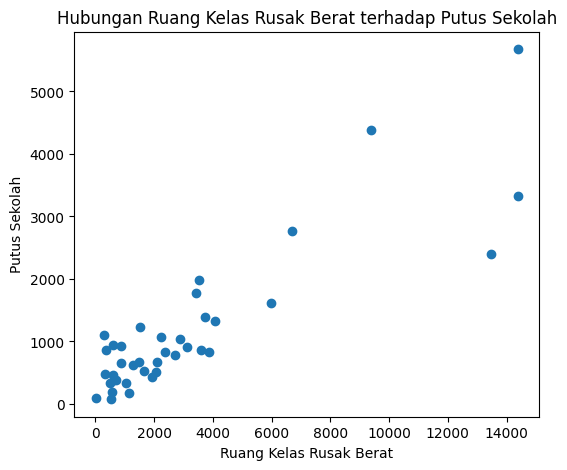

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(df["ruang_kelasrusak_berat"], df[TARGET])
plt.xlabel("Ruang Kelas Rusak Berat")
plt.ylabel("Putus Sekolah")
plt.title("Hubungan Ruang Kelas Rusak Berat terhadap Putus Sekolah")
plt.show()

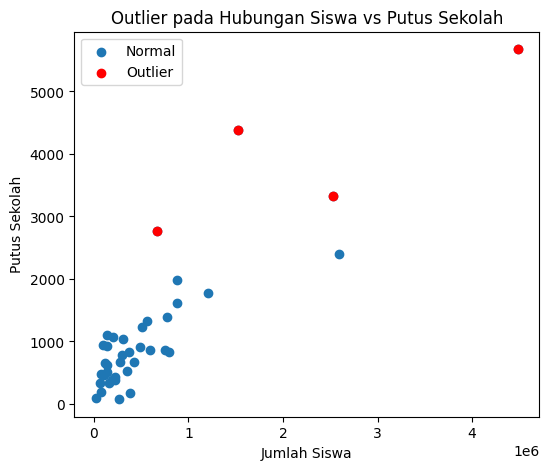

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(df["siswa"], df[TARGET], label="Normal")

# highlight outlier
plt.scatter(
    df.loc[out_putus.index, "siswa"],
    df.loc[out_putus.index, TARGET],
    color="red",
    label="Outlier"
)

plt.xlabel("Jumlah Siswa")
plt.ylabel("Putus Sekolah")
plt.title("Outlier pada Hubungan Siswa vs Putus Sekolah")
plt.legend()
plt.show()